In [27]:
import bt
import pandas

In [28]:
import talib as ta

In [29]:
import dtale

In [30]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [31]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')

In [57]:
rsi = data.apply(lambda x: ta.RSI(x, timeperiod=14))

In [58]:
## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = rsi.copy()
# set appropriate target weights

In [59]:
tw[:] = 0

In [60]:
tw

,spy
Date,
2010-01-04,0.0
2010-01-05,0.0
2010-01-06,0.0
2010-01-07,0.0
2010-01-08,0.0
...,...
2024-05-13,0.0
2024-05-14,0.0
2024-05-15,0.0


In [61]:
tw[rsi <=  20] = 1
tw[rsi >= 80] = -1
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[rsi.isnull()] = 0.0

In [62]:
tw

,spy
Date,
2010-01-04,0.0
2010-01-05,0.0
2010-01-06,0.0
2010-01-07,0.0
2010-01-08,0.0
...,...
2024-05-13,0.0
2024-05-14,0.0
2024-05-15,0.0


In [68]:
dtale.show(tmp)

Exception on /dtale/main/highLightTitle.png [GET]
Traceback (most recent call last):
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/dtale/views.py", line 1238, in view_main
    if not global_state.contains(data_id):
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site

2024-05-20 17:45:36,752 - ERROR    - Exception on /dtale/main/highLightTitle.png [GET]
Traceback (most recent call last):
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/Users/zlying/opt/miniconda3/envs/py310/lib/python3.10/site-packages/dtale/views.py", line 1238, in view_main
    if not global_state.contains(data_id):
  File "/Users/zlying/opt/mini

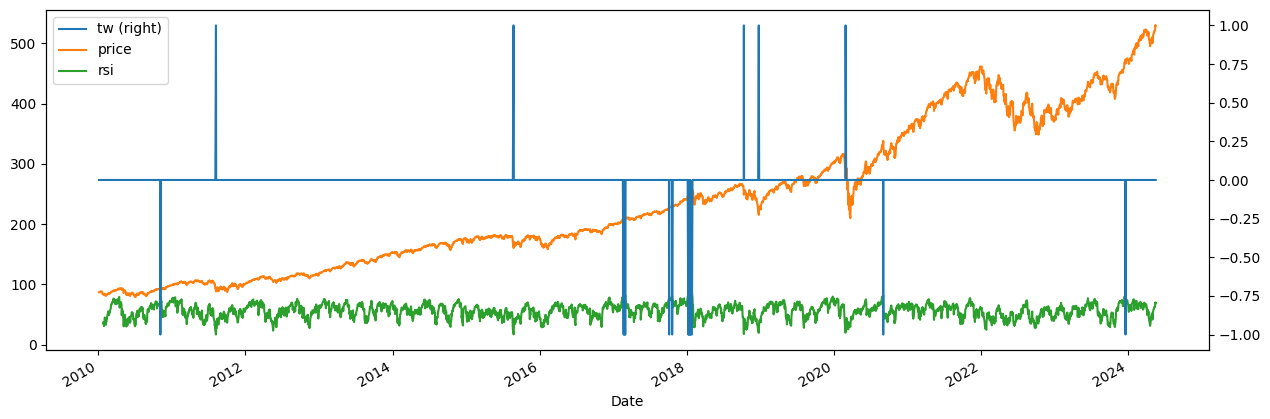

In [63]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, rsi)
tmp.columns = ['tw', 'price', 'rsi']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [64]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

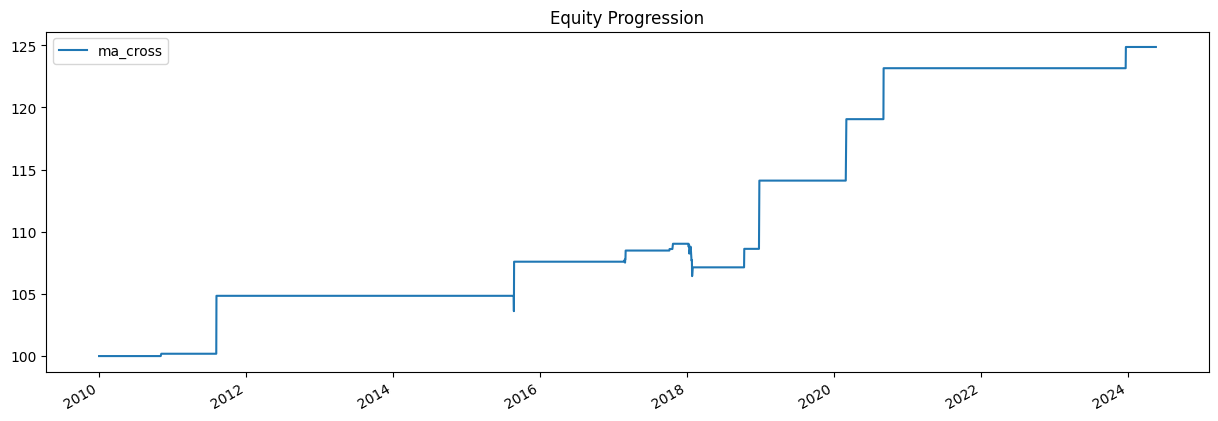

In [65]:
res.plot();

In [66]:
res.display()

Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-05-17
Risk-free rate       0.00%

Total Return         24.86%
Daily Sharpe         0.59
Daily Sortino        3.02
CAGR                 1.56%
Max Drawdown         -2.39%
Calmar Ratio         0.65

MTD                  0.00%
3m                   0.00%
6m                   1.39%
YTD                  0.00%
1Y                   1.39%
3Y (ann.)            0.46%
5Y (ann.)            1.82%
10Y (ann.)           1.76%
Since Incep. (ann.)  1.56%

Daily Sharpe         0.59
Daily Sortino        3.02
Daily Mean (ann.)    1.58%
Daily Vol (ann.)     2.66%
Daily Skew           24.05
Daily Kurt           641.70
Best Day             5.05%
Worst Day            -1.18%

Monthly Sharpe       0.63
Monthly Sortino      3.44
Monthly Mean (ann.)  1.58%
Monthly Vol (ann.)   2.50%
Monthly Skew         5.25
Monthly Kurt         30.09
Best Month           5.05%
Worst Month          -1.74%

Yearly S